In [1]:
import sys
import os
import json
import numpy as np
import glob
import copy
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors

import importlib
import util_human_model_comparison
import util_figures_psychophysics

sys.path.append('/packages/msutil')
import util_figures


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


# Specify scope of all models to compare (regex must grab all model output directories)
regex_model_dir = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v02/arch_*/'
tmp_list_model_dir = sorted(glob.glob(regex_model_dir))

basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'

# Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_lowharm_v01_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_transposedtones_v01_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_freqshifted_v01_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_mistunedharm_v01_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_altphase_v01_bestckpt_results_dict.json',
}

# Speicfy human_results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]
list_valid_metric = []
list_arch_metric = []
list_model_dir = []
list_results_dicts = []

disp_step = 50
for idx, model_dir in enumerate(tmp_list_model_dir):
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
    fn_arch_config = os.path.join(model_dir, basename_arch_config)
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek])
    
    include_model_flag = True
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False 
    
    if include_model_flag:
        list_model_dir.append(model_dir)
        list_valid_metric.append(calc_best_metric(fn_valid_metric))
        list_arch_metric.append(calc_num_layers(fn_arch_config))
        results_dicts = {}
        for ek in experiment_keys:
            results_dicts[ek] = load_results_dict(fn_result_dict[ek])
        list_results_dicts.append(results_dicts)
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)

print('Number of included networks:', len(list_valid_metric))


/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0000/ True
/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0050/ True
/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0100/ True
/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0150/ True
/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0200/ True
/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0250/ True
/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0300/ True
/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0350/ True
Number of included networks: 400


In [2]:
IDX = np.argsort(list_valid_metric)[::-1]
for i in range(10):
    print("'"+list_model_dir[IDX[i]]+"',")


'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0191/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0302/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0288/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0335/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0346/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0286/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0083/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0154/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0190/',
'/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v02/arch_0338/',


In [23]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

np.random.seed(858)

experiment_to_compfunc_map = {
    'bernox2005': util_human_model_comparison.compare_bernox2005,
    'transposedtones': util_human_model_comparison.compare_transposedtones,
    'freqshiftedcomplexes': util_human_model_comparison.compare_freqshiftedcomplexes,
    'mistunedharmonics': util_human_model_comparison.compare_mistunedharmonics,
    'altphasecomplexes': util_human_model_comparison.compare_altphasecomplexes_hist,
}

experiment_to_compfunc_kwargs_map = {
    'bernox2005': {},
    'transposedtones': {},
    'freqshiftedcomplexes': {},
    'mistunedharmonics': {},
    'altphasecomplexes': {},
}

experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]

dict_list_human_model_comparison = {}
for key in experiment_keys:
    print('comparing:', key)
    list_human_model_comparison = []
    human_results_dict = experiment_to_human_results_map[key]
    for results_dicts in list_results_dicts:
        model_results_dict = results_dicts[key]
        compfunc = experiment_to_compfunc_map[key]
        compfunc_kwargs = experiment_to_compfunc_kwargs_map[key]
        metric_comparison = compfunc(human_results_dict, model_results_dict, **compfunc_kwargs)
        if len(np.array(metric_comparison).reshape([-1])) == 2:
            metric_comparison = metric_comparison[0]
            if np.isnan(metric_comparison):
                metric_comparison = 0
        list_human_model_comparison.append(metric_comparison)
    dict_list_human_model_comparison[key] = list_human_model_comparison


comparing: bernox2005
comparing: altphasecomplexes
comparing: freqshiftedcomplexes
comparing: mistunedharmonics
comparing: transposedtones


In [26]:
N = len(list_valid_metric)
rank_sum_valid = np.array(list_valid_metric).argsort().argsort()
rank_sum_valid = rank_sum_valid.max() - rank_sum_valid + 1 # Lower rank = better task performance

# Rank each experiment, sum ranks, and then rank the summed ranks
rank_sum_psych = np.zeros_like(rank_sum_valid)
for ek in sorted(dict_list_human_model_comparison.keys()):
    rank_sum_ek = np.array(dict_list_human_model_comparison[ek]).argsort().argsort()
    rank_sum_ek = rank_sum_ek.max() - rank_sum_ek + 1
    rank_sum_psych += rank_sum_ek
rank_sum_psych = rank_sum_psych.argsort().argsort() # Lower rank = more human-like psychophysical result

# plt.figure()
# plt.plot(rank_sum_valid, rank_sum_psych, '.')
# plt.show()

for num_layers in np.unique(list_arch_metric):
    FIDX = np.array(list_arch_metric) == num_layers
    print('====== num_layers={} ({} networks) ======'.format(num_layers, FIDX.sum()))
    print('rank_sum_valid: ', rank_sum_valid[FIDX].min(), rank_sum_valid[FIDX].mean(), np.median(rank_sum_valid[FIDX]))
    print('rank_sum_psych: ', rank_sum_psych[FIDX].min(), rank_sum_psych[FIDX].mean(), np.median(rank_sum_psych[FIDX]))


FIDX_SINGLE = np.array(list_arch_metric) <= 1
FIDX_MULTI = np.array(list_arch_metric) > 1
print('N FIDX_SINGLE = {}'.format(FIDX_SINGLE.sum()))
print('N FIDX_MULTI = {}'.format(FIDX_MULTI.sum()))


print('--- VALID METRICS ---')
metrics_valid = np.array(list_valid_metric)
print(scipy.stats.ranksums(metrics_valid[FIDX_SINGLE], metrics_valid[FIDX_MULTI]))
print(scipy.stats.ttest_ind(metrics_valid[FIDX_SINGLE], metrics_valid[FIDX_MULTI]))

print('--- COMBINED PSYCHOPHYSICS RANKS ---')
print(scipy.stats.ranksums(rank_sum_psych[FIDX_SINGLE], rank_sum_psych[FIDX_MULTI]))
print(scipy.stats.ttest_ind(rank_sum_psych[FIDX_SINGLE], rank_sum_psych[FIDX_MULTI]))

for ek in sorted(dict_list_human_model_comparison.keys()):
    metrics_human_model = np.array(dict_list_human_model_comparison[ek])
    print('--- {} ---'.format(ek))
    print(scipy.stats.ranksums(metrics_human_model[FIDX_SINGLE], metrics_human_model[FIDX_MULTI]))
    print(scipy.stats.ttest_ind(metrics_human_model[FIDX_SINGLE], metrics_human_model[FIDX_MULTI]))

print(scipy.stats.spearmanr(metrics_valid, rank_sum_psych))
print(scipy.stats.spearmanr(rank_sum_valid, rank_sum_psych))


====== num_layers=1 (54 networks) ======
rank_sum_valid:  33 307.4074074074074 356.5
rank_sum_psych:  176 333.75925925925924 349.5
====== num_layers=2 (52 networks) ======
rank_sum_valid:  14 177.51923076923077 182.0
rank_sum_psych:  0 203.92307692307693 229.5
====== num_layers=3 (47 networks) ======
rank_sum_valid:  6 174.0212765957447 183.0
rank_sum_psych:  28 170.04255319148936 153.0
====== num_layers=4 (50 networks) ======
rank_sum_valid:  7 174.0 161.0
rank_sum_psych:  20 169.54 167.5
====== num_layers=5 (45 networks) ======
rank_sum_valid:  1 182.37777777777777 169.0
rank_sum_psych:  3 185.86666666666667 165.0
====== num_layers=6 (52 networks) ======
rank_sum_valid:  3 181.96153846153845 175.5
rank_sum_psych:  17 180.8653846153846 186.0
====== num_layers=7 (53 networks) ======
rank_sum_valid:  5 193.18867924528303 182.0
rank_sum_psych:  2 175.9811320754717 178.0
====== num_layers=8 (47 networks) ======
rank_sum_valid:  12 203.87234042553192 238.0
rank_sum_psych:  4 161.8723404255

0.811657119434471 5.805104443741501e-95
0.42905834591311376 2.4055774950304533e-19
0.5931741295932158 2.234887559223173e-39
0.2459923834899057 6.319190802977815e-07
0.028605931152024505 0.5683759654884804


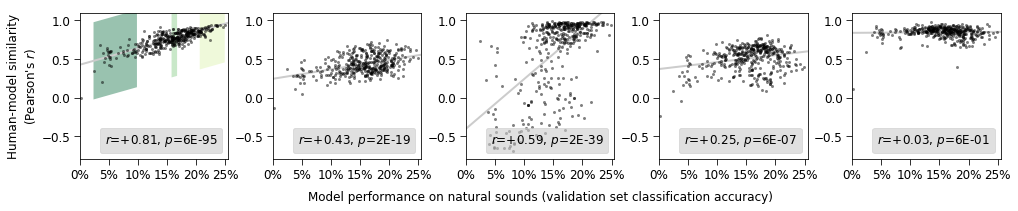

In [27]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

sort_idx = np.flip(np.argsort(list_valid_metric))

sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
sorted_list_results_dicts = np.array(list_results_dicts)[sort_idx]

list_partition = [
    ((359, 399), '#006837'),
    ((180, 220), '#78c679'),
    ((0, 40), '#d9f0a3'),
]
ALPHA = 0.4

experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]

NROWS = 1
NCOLS = len(experiment_keys)
figsize = (3.3*NCOLS, 2.7*NROWS)
gridspec_kw = {
    'wspace': 0.3
}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = ax.reshape([NROWS, NCOLS])

for ax_idx, key in enumerate(experiment_keys):
    results_dict_input = experiment_to_human_results_map[key]
    util_human_model_comparison.make_human_model_comparison_plot(
        ax[0, ax_idx],
        list_valid_metric,
        dict_list_human_model_comparison[key])
    
    if ax_idx > 0:
        ax[0, ax_idx].set_ylabel(None)
    if ax_idx == len(experiment_keys) // 2:
        ax[0, ax_idx].set_xlabel("Model performance on natural sounds (validation set classification accuracy)", labelpad=9)
    else:
        ax[0, ax_idx].set_xlabel(None)
    
    if key == 'bernox2005':
        for partition, color in list_partition:
            x = 100 * np.array([sorted_list_valid_metric[partition[0]],
                                sorted_list_valid_metric[partition[1] - 1]])
            m, b = np.polyfit(100.0 * np.array(list_valid_metric),
                              np.array(dict_list_human_model_comparison[key]),
                              1)
            tmp = 0.5
            xy = np.array([
                [x[0], m * x[0] + b - tmp],
                [x[1], m * x[1] + b - tmp],
                [x[1], m * x[1] + b + tmp],
                [x[0], m * x[0] + b + tmp],
            ])
            kwargs_polygon = {
                'ec': color,
                'fc': color,
                'lw': 0.0,
                'fill': True,
                'alpha': ALPHA,
                'zorder': -1,
            }
            patch = matplotlib.patches.Polygon(xy, **kwargs_polygon)

            ax[0, ax_idx].add_patch(patch)

plt.show()

# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0.1, transparent=False)


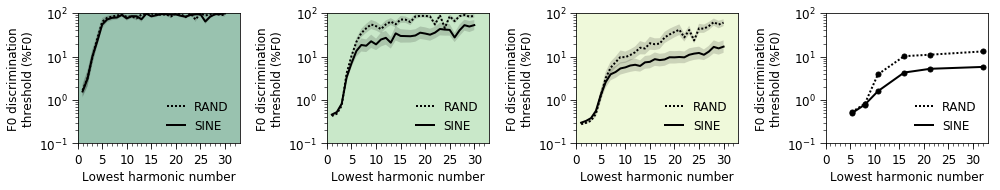

In [28]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

np.random.seed(858)

sort_idx = np.flip(np.argsort(list_valid_metric))

sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
sorted_list_results_dicts = np.array(list_results_dicts)[sort_idx]

experiment_to_plot_fcn_map = {
    'bernox2005': util_figures_psychophysics.make_bernox_threshold_plot,
    'transposedtones': util_figures_psychophysics.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_figures_psychophysics.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_plot,
    'altphasecomplexes': util_figures_psychophysics.make_altphase_histogram_plot,
}

ALPHA = 0.4
list_partition = [
    ((359, 399), '#006837'),
    ((180, 220), '#78c679'),
    ((0, 40), '#d9f0a3'),
    'HUMAN',
]

experiment_keys = [
    'bernox2005',
]


NROWS = len(experiment_keys)
NCOLS = len(list_partition)
figsize = (3.5*NCOLS, 2.75*NROWS)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = ax.reshape([NROWS, NCOLS])

for c_idx, partition_obj in enumerate(list_partition):
    if isinstance(partition_obj, tuple) and isinstance(partition_obj[0], tuple):
        partition = partition_obj[0]
        color = partition_obj[1]
    else:
        partition = partition_obj
        color = None
    
    for r_idx, key in enumerate(experiment_keys):
        flag_comparison_plot = False
        if isinstance(partition, str):
            flag_comparison_plot = 'comp' in partition.lower()
            results_dict_input = experiment_to_human_results_map[key]
        else:
            results_dict_input = []
            for idx in range(*partition):
                results_dict_input.append(sorted_list_results_dicts[idx][key])
        
        if flag_comparison_plot:
            util_human_model_comparison.make_human_model_comparison_plot(
                ax[r_idx, c_idx],
                list_valid_metric,
                dict_list_human_model_comparison[key])
        
        else:
            plot_fcn = experiment_to_plot_fcn_map[key]
            kwargs = {
                'include_yerr': True,
            }
            if isinstance(partition, str) and ('human' in partition.lower()):
                kwargs['include_yerr'] = False
            plot_fcn(ax[r_idx, c_idx], results_dict_input, **kwargs)
        
        if color is not None:
            ax[r_idx, c_idx].patch.set_facecolor(color)
            ax[r_idx, c_idx].patch.set_alpha(ALPHA)

plt.tight_layout()
plt.show()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'psychophysics_human_model_correlation_inset_bernox2005.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0.1, transparent=False)
# print(save_fn)

# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0.1, transparent=False)


0.811657119434471 5.805104443741501e-95
0.42905834591311376 2.4055774950304533e-19
0.5931741295932158 2.234887559223173e-39
0.2459923834899057 6.319190802977815e-07
0.028605931152024505 0.5683759654884804


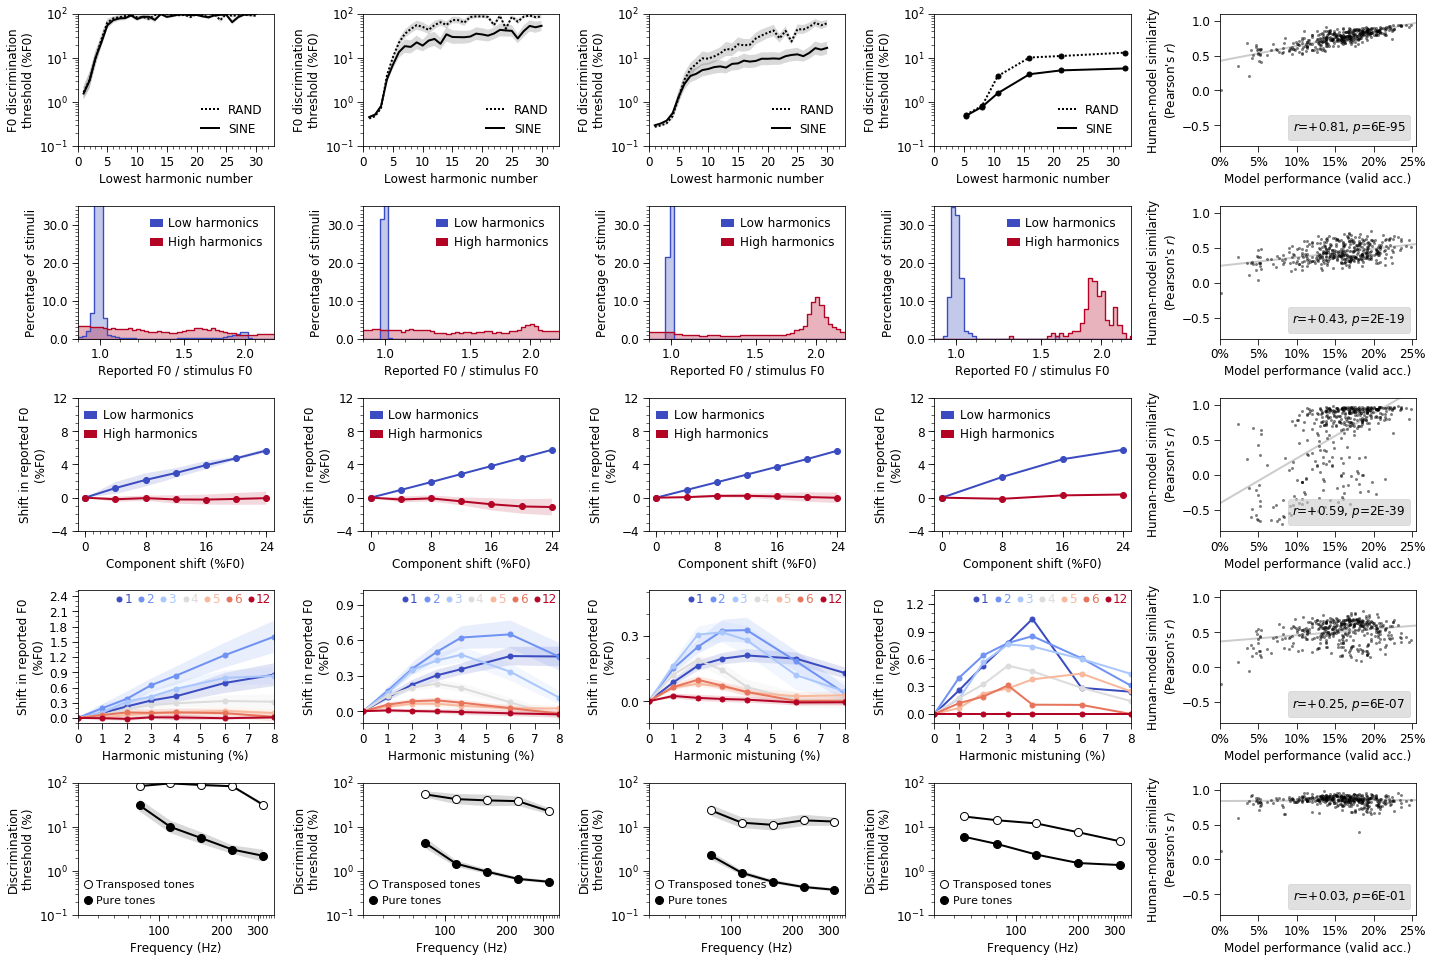

In [29]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

np.random.seed(858)

sort_idx = np.flip(np.argsort(list_valid_metric))

sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
sorted_list_results_dicts = np.array(list_results_dicts)[sort_idx]

experiment_to_plot_fcn_map = {
    'bernox2005': util_figures_psychophysics.make_bernox_threshold_plot,
    'transposedtones': util_figures_psychophysics.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_figures_psychophysics.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_plot,
    'altphasecomplexes': util_figures_psychophysics.make_altphase_histogram_plot,
}

ALPHA = 0.4
list_partition = [
    (359, 399),
    (180, 220),
    (0, 40),
    'HUMAN',
    'COMPARE',
]

experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]


NROWS = len(experiment_keys)
NCOLS = len(list_partition)
figsize = (4*NCOLS*0.9/0.9, 3*NROWS*0.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = ax.reshape([NROWS, NCOLS])

for c_idx, partition_obj in enumerate(list_partition):
    if isinstance(partition_obj, tuple) and isinstance(partition_obj[0], tuple):
        partition = partition_obj[0]
        color = partition_obj[1]
    else:
        partition = partition_obj
        color = None
    
    for r_idx, key in enumerate(experiment_keys):
        flag_comparison_plot = False
        if isinstance(partition, str):
            flag_comparison_plot = 'comp' in partition.lower()
            results_dict_input = experiment_to_human_results_map[key]
        else:
            results_dict_input = []
            if isinstance(partition, tuple):
                partition = range(*partition)
            for idx in partition:
                results_dict_input.append(sorted_list_results_dicts[idx][key])
#                 if r_idx == 0:
#                     print(sorted_list_model_dir[idx])
        
        if flag_comparison_plot:
            util_human_model_comparison.make_human_model_comparison_plot(
                ax[r_idx, c_idx],
                list_valid_metric,
                dict_list_human_model_comparison[key])
        
        else:
            plot_fcn = experiment_to_plot_fcn_map[key]
            kwargs = {
                'include_yerr': True,
            }
            if isinstance(partition, str) and ('human' in partition.lower()):
                kwargs['include_yerr'] = False
            plot_fcn(ax[r_idx, c_idx], results_dict_input, **kwargs)
        
        if color is not None:
            ax[r_idx, c_idx].patch.set_facecolor(color)
            ax[r_idx, c_idx].patch.set_alpha(ALPHA)
        
#         if c_idx in [1,2,3]:
#             ax[r_idx, c_idx].set_ylabel(None)

plt.tight_layout()
plt.show()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'psychophysics_human_model_correlation_supplement.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0.1, transparent=False)
# print(save_fn)

# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0.1, transparent=False)


N=34 of 346
N=5 of 54
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34], [32, 100, 123, 125, 149], 'HUMAN', 'COMPARE']
0.811657119434471 5.805104443741501e-95
med=(16.5621949352324,0.7914019829876282), err=(0.2527837288562819,0.005121967650207359)
med=(10.19375172033906,0.6345110489778726), err=(0.7003430090980619,0.023883792723048976)
0.42905834591311376 2.4055774950304533e-19
med=(16.553353810310362,0.4378099601740006), err=(0.2502009898112108,0.009726671912862306)
med=(10.25245321020484,0.3377548654127978), err=(0.7215736040561337,0.014297259642402282)
0.5931741295932158 2.234887559223173e-39
med=(16.556126026064156,0.8569403202777208), err=(0.2589821097555551,0.015369211730977743)
med=(10.207195849716664,-0.03376671692922619), err=(0.7542476885728675,0.2389376349867971)
0.2459923834899057 6.319190802977815e-07
med=(16.54329944998026,0.5564062320667299), err=(0.24841785113847345,0.00891078295101989)
med=(1

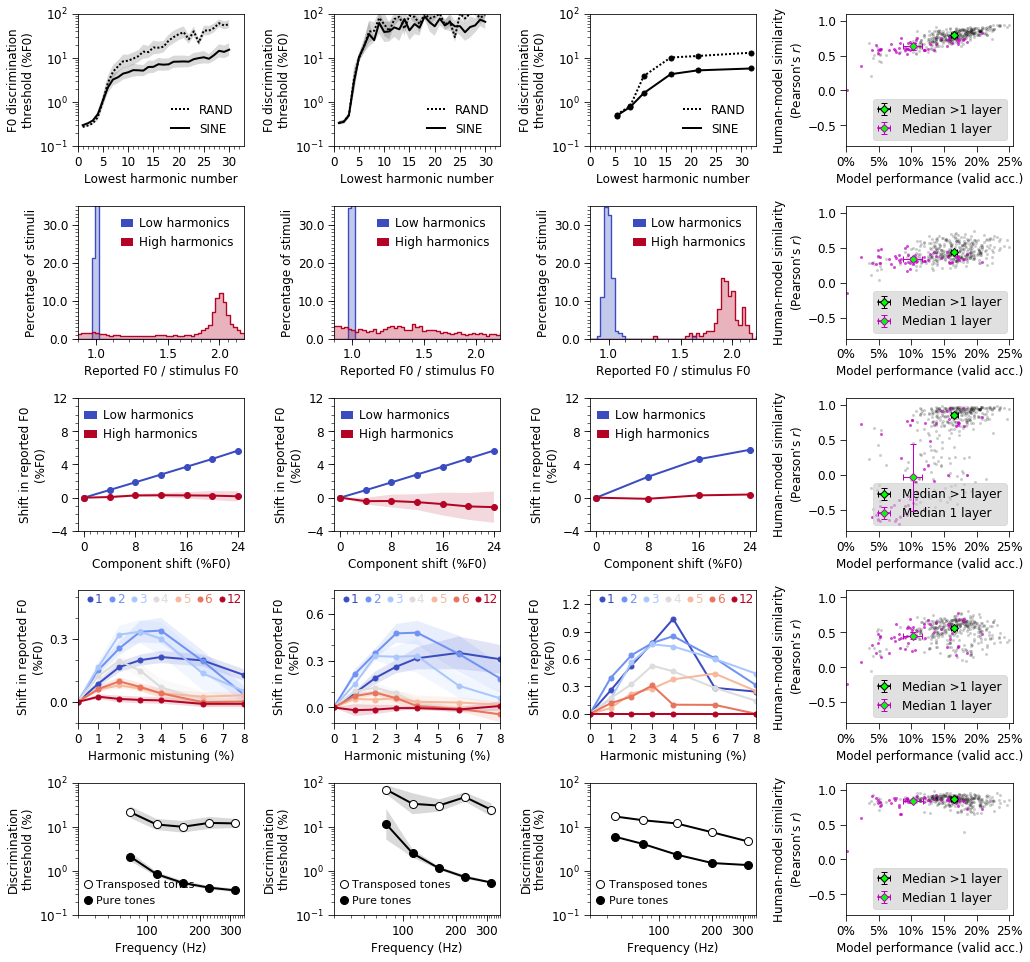

In [30]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

np.random.seed(858)

sort_idx = np.flip(np.argsort(list_valid_metric))
sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_arch_metric = np.array(list_arch_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
sorted_list_results_dicts = np.array(list_results_dicts)[sort_idx]

list_partition = []

# Top 10% of multi-conv-layer archs
filt_idx = np.arange(0, len(sorted_list_arch_metric))
filt_idx = filt_idx[np.array(sorted_list_arch_metric) > 1]
N = (len(filt_idx)//10)
list_partition.append( filt_idx[:N].tolist() )
print('N={} of {}'.format(N, len(filt_idx)))

# Top 10% of single-conv-layer archs
filt_idx = np.arange(0, len(sorted_list_arch_metric))
filt_idx = filt_idx[np.array(sorted_list_arch_metric) == 1]
N = (len(filt_idx)//10)
list_partition.append( filt_idx[:N].tolist() )
print('N={} of {}'.format(N, len(filt_idx)))

# list_partition.append(list(range(40)))
# for tmp in [1]:#range(1,9):
#     filt_idx = np.arange(0, len(sorted_list_arch_metric))
#     filt_idx = filt_idx[np.array(sorted_list_arch_metric) == tmp]
#     print(len(filt_idx))
#     list_partition.append(filt_idx[:5].tolist())
list_partition.append('HUMAN')
list_partition.append('COMPARE')

print(list_partition)


experiment_to_plot_fcn_map = {
    'bernox2005': util_figures_psychophysics.make_bernox_threshold_plot,
    'transposedtones': util_figures_psychophysics.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_figures_psychophysics.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_plot,
    'altphasecomplexes': util_figures_psychophysics.make_altphase_histogram_plot,
}


experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]


NROWS = len(experiment_keys)
NCOLS = len(list_partition)
figsize = (4*NCOLS*0.9, 3*NROWS*0.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = ax.reshape([NROWS, NCOLS])

for c_idx, partition in enumerate(list_partition):
    for r_idx, key in enumerate(experiment_keys):
        flag_comparison_plot = False
        if isinstance(partition, str):
            flag_comparison_plot = 'comp' in partition.lower()
            results_dict_input = experiment_to_human_results_map[key]
        elif isinstance(partition, int):
            results_dict_input = sorted_list_results_dicts[partition][key]
        elif isinstance(partition, list):
            results_dict_input = []
            for idx in partition:
                results_dict_input.append(sorted_list_results_dicts[idx][key])
        else:
            results_dict_input = []
            for idx in range(*partition):
                results_dict_input.append(sorted_list_results_dicts[idx][key])
        
        if flag_comparison_plot:
            kwargs_make_human_model_comparison_plot = {
                'list_accent_indexes': [
                    np.array(list_arch_metric)>1,
                    np.array(list_arch_metric)==1,
                ],
                'list_accent_kwargs_plot': [
                    {'color': 'k', 'markersize': 3.0, 'alpha': 0.2, 'label': 'Median >1 layer'},
                    {'color': 'm', 'markersize': 3.0, 'alpha': 0.7, 'label': 'Median 1 layer'},
                ]
            }
            util_human_model_comparison.make_human_model_comparison_plot(
                ax[r_idx, c_idx],
                list_valid_metric,
                dict_list_human_model_comparison[key],
                **kwargs_make_human_model_comparison_plot)
        
        else:
            plot_fcn = experiment_to_plot_fcn_map[key]
            kwargs = {
                'include_yerr': True,
            }
            if isinstance(partition, str) and ('human' in partition.lower()):
                kwargs['include_yerr'] = False
            plot_fcn(ax[r_idx, c_idx], results_dict_input, **kwargs)

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'psychophysics_human_model_correlation_supplement_single_vs_multi_layer.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0.1, transparent=False)
# print(save_fn)


In [ ]:
# SAVE MODEL AND HUMAN-MODEL COMPARISON DATA TO A SINGLE JSON FILE FOR STATISTICAL TESTS IN MATLAB

import sys
import os
import pdb
import json
import numpy as np
import glob
import copy
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_figures_psychophysics

sys.path.append('/packages/msutil')
import util_figures
import util_misc

importlib.reload(util_human_model_comparison)

list_regex_model_dir = [
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species004_spont070_BWlinear_IHC3000Hz_IHC7order/arch_0???/', 'BWlinear'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0???/', 'BW05eN1'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'BW10eN1'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0???/', 'BW20eN1'),
    
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'natural'),
    ('/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_neg10pos10_filter_signalLPv01/arch_0???/', 'natural_lp'),
    ('/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_neg10pos10_filter_signalHPv00/arch_0???/', 'natural_hp'),
    ('/saved_models/arch_search_v02_topN/PND_mfcc_PNDv08PYSmatched12_TLASmatched12_snr_neg10pos10_phase3/arch_0???/', 'matched_synthetic'),
    ('/saved_models/arch_search_v02_topN/PND_mfcc_PNDv08PYSnegated12_TLASmatched12_snr_neg10pos10_phase3/arch_0???/', 'anti_matched_synthetic'),
    ('/saved_models/arch_search_v02_topN/PND_v08spch_noise_TLAS_snr_neg10pos10/arch_0???/', 'spch_only'),
    ('/saved_models/arch_search_v02_topN/PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0???/', 'inst_only'),
    
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'noise_high'),
    ('/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_pos10pos30/arch_0???/', 'noise_low'),
    ('/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_posInf/arch_0???/', 'noise_none'),
    
    ('/saved_models/arch_search_v02_topN/f0_label_024/arch_0???/', 'f0_label_024'),
    ('/saved_models/arch_search_v02_topN/f0_label_048/arch_0???/', 'f0_label_048'),
    ('/saved_models/arch_search_v02_topN/f0_label_096/arch_0???/', 'f0_label_096'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'f0_label_192'),
    ('/saved_models/arch_search_v02_topN/f0_label_384/arch_0???/', 'f0_label_384'),
    
    ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', 'IHC0050Hz_cf100'),
    ('/saved_models/arch_search_v02_topN/REDOsr2000_cfI100_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', 'IHC0050Hz_cfI100'),
    ('/saved_models/arch_search_v02_topN/REDOsr2000_cfI250_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', 'IHC0050Hz_cfI250'),
    ('/saved_models/arch_search_v02_topN/REDOsr2000_cfI500_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', 'IHC0050Hz_cfI500'),
    ('/saved_models/arch_search_v02_topN/REDOsr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', 'IHC0050Hz_cf1000'),

    ('/saved_models/arch_search_v02_topN/REDOsr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', 'IHC0050Hz'),
    ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0320Hz_IHC7order/arch_0???/', 'IHC0320Hz'),
    ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC1000Hz_IHC7order/arch_0???/', 'IHC1000Hz'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'IHC3000Hz'),
    ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC6000Hz_IHC7order/arch_0???/', 'IHC6000Hz'),
    ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC9000Hz_IHC7order/arch_0???/', 'IHC9000Hz'),
]

# Specify basename for validation metrics
basename_valid_metrics = 'validation_metrics.json'

# Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_lowharm_v01_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_transposedtones_v01_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_freqshifted_v01_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_mistunedharm_v01_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_altphase_v01_bestckpt_results_dict.json',
    'f0dlspl': 'EVAL_SOFTMAX_testspl_v03_bestckpt_results_dict.json',
}

# Specify human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
#     'f0dlspl': util_human_model_comparison.get_human_results_dict_pure_tone_spl(threshold_level=0)
}

# Specify function used to compare human and model results_dict
experiment_to_compfunc_map = {
    'bernox2005': util_human_model_comparison.compare_bernox2005,
    'transposedtones': util_human_model_comparison.compare_transposedtones,
    'freqshiftedcomplexes': util_human_model_comparison.compare_freqshiftedcomplexes,
    'mistunedharmonics': util_human_model_comparison.compare_mistunedharmonics,
    'altphasecomplexes': util_human_model_comparison.compare_altphasecomplexes_hist,
}

SUPER_DATA_DICT = {}
entry_count = 0

# Iterate over list_regex_model_dir (regex_model_dir globs all "subjects" for a single model condition)
for (regex_model_dir, MODEL_TAG) in list_regex_model_dir:
    list_model_dir = sorted(glob.glob(regex_model_dir)) # List of models within a condition
    
    print('###', MODEL_TAG, len(list_model_dir))
    
    # Get the list of experiments that were run on the current model condition
    experiment_key_list = []
    for ek in sorted(experiment_to_basename_map.keys()):
        fn_result_dict = os.path.join(list_model_dir[0], experiment_to_basename_map[ek])
        if os.path.exists(fn_result_dict):
            experiment_key_list.append(ek)
    
    # Iterate over list of experiments that were run on the current model condition
    for ek in experiment_key_list:
        DATA_NAME = '{}-{}'.format(MODEL_TAG, ek)
        DATA_DICT = {}
        list_model_results_dict = [] # Collect each results_dict for current model + experiment
        
        # Iterate over "subjects" within a model condition
        for model_dir in list_model_dir:
            fn_result_dict = os.path.join(model_dir, experiment_to_basename_map[ek])
            if 'snr_pos' in model_dir:
                if ek == 'bernox2005':
                    fn_result_dict = os.path.join(model_dir, 'EVAL_SOFTMAX_lowharm_v04_bestckpt_results_dict.json')
                    print(fn_result_dict)
                if ek == 'transposedtones':
                    fn_result_dict = os.path.join(model_dir, 'EVAL_SOFTMAX_transposedtones_v02_bestckpt_results_dict.json')
                    print(fn_result_dict)
            with open(fn_result_dict) as f:
                model_results_dict = json.load(f)
            list_model_results_dict.append(model_results_dict)
            
            # If human-model comparisons are possible, include those metrics in DATA_DICT
            if ek in experiment_to_human_results_map.keys():
                human_results_dict = experiment_to_human_results_map[ek]
                compfunc = experiment_to_compfunc_map[ek]
                coef, pval = compfunc(human_results_dict, model_results_dict)
                if 'human_model_similarity_coef' not in DATA_DICT.keys():
                    DATA_DICT['human_model_similarity_coef'] = []
                if 'human_model_similarity_pval' not in DATA_DICT.keys():
                    DATA_DICT['human_model_similarity_pval'] = []
                DATA_DICT['human_model_similarity_coef'].append(coef)
                DATA_DICT['human_model_similarity_pval'].append(pval)
            
            # If F0 discrimination thresholds are in results_dict, include in DATA_DICT
            if 'f0dl' in model_results_dict.keys():
                if 'f0dl' not in DATA_DICT.keys():
                    DATA_DICT['f0dl'] = []
                DATA_DICT['f0dl'].append(model_results_dict['f0dl'])
            # For F0 discrimination experiments, also include condition labels
            if 'bernox2005' in ek:
                for key in ['low_harm', 'phase_mode']:
                    DATA_DICT[key] = model_results_dict[key]
            if 'transposedtones' in ek:
                for key in ['f_carrier', 'f0_ref']:
                    DATA_DICT[key] = model_results_dict[key]
                tt_collapsed_results_dict = util_human_model_comparison.combine_transposedtones_thresholds(
                    model_results_dict,
                    threshold_cap=100.0)
                if 'tt_combined_f0dl' not in DATA_DICT.keys():
                    DATA_DICT['tt_combined_f0dl'] = []
                DATA_DICT['tt_combined_f0dl'].append(tt_collapsed_results_dict['f0dl'])
                DATA_DICT['tt_combined_f_carrier'] = tt_collapsed_results_dict['f_carrier']
                DATA_DICT['tt_combined_f0_ref'] = tt_collapsed_results_dict['f0_ref']
            if 'snr' in ek:
                for key in ['snr_per_component']:
                    DATA_DICT[key] = model_results_dict[key]
            if 'spl' in ek:
                for key in ['dbspl']:
                    DATA_DICT[key] = model_results_dict[key]
        
        if 'bernox2005' in ek:
            # Compute correlation between human_results_dict and subject-combined results_dict
            human_results_dict = experiment_to_human_results_map[ek]
            compfunc = experiment_to_compfunc_map[ek]
            coef, pval = compfunc(human_results_dict, list_model_results_dict)
            DATA_DICT['human_combined_model_similarity_coef'] = coef
            DATA_DICT['human_combined_model_similarity_pval'] = pval
            
            sine_coef, sine_pval = compfunc(human_results_dict,
                                            list_model_results_dict,
                                            restrict_phase_modes=[0])
            rand_coef, rand_pval = compfunc(human_results_dict,
                                            list_model_results_dict,
                                            restrict_phase_modes=[1])
            DATA_DICT['human_combined_model_similarity_sine_coef'] = sine_coef
            DATA_DICT['human_combined_model_similarity_sine_pval'] = sine_pval
            DATA_DICT['human_combined_model_similarity_rand_coef'] = rand_coef
            DATA_DICT['human_combined_model_similarity_rand_pval'] = rand_pval
            
            print(DATA_NAME)
            print('COMBINED', coef, pval)
            print('SINEONLY', sine_coef, sine_pval)
            print('RANDONLY', rand_coef, rand_pval)
        
        # Store DATA_DICT in SUPER_DATA_DICT
        SUPER_DATA_DICT[DATA_NAME] = DATA_DICT
        entry_count += 1

#         print('\n', entry_count, DATA_NAME)
#         for k in sorted(DATA_DICT.keys()):
#             print('<>', k, np.array(DATA_DICT[k]).shape)


In [ ]:
# print('<><><> [BEGIN] WRITING SUPER_DATA_DICT TO JSON FILE <><><>')
# with open('tmp.json', 'w') as f:
#     json.dump(SUPER_DATA_DICT, f, sort_keys=True, cls=util_misc.NumpyEncoder)
# print('<><><> [END] WRITING SUPER_DATA_DICT TO JSON FILE <><><>')
